### Imports:

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset

import copy
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

EPS = 1.0e-7
lamb = 0.01

In [3]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
results_dir = "/content/gdrive/My_Drive/Colab Notebooks/TEACHING/"

### Loading the MNIST dataset:

In [4]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

### Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [5]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)




# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

## Below is the main class for a classifier parameterized by a neural network. Here we changed the loss calcualtion from NLL to CrossEntropyLoss

In [6]:
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()

        self.classnet = classnet 
        self.ce = nn.CrossEntropyLoss(reduction="none")
        # CHANGED TO CROSS Entropy

    def classify(self, x):

        y_pred = self.classnet(x)
        y_pred =  y_pred.argmax(dim=1)

        return y_pred

    def forward(self, x, y, reduction="avg"):

        y_pred = self.classnet(x)
        loss = self.ce(y_pred, y.long())
        
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

### Evaluation

In [7]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### Training procedure

In [8]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

#### Initialize dataloaders

In [9]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### Initialize hyperparameters

In [10]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

### Generation of ANNs and the Max param ANN. Implementation fo the genotype with integer encoding

In [29]:
genotype = [0, 1, 2, 0, 1, 5]


kernels = [8, 16, 32]  # max 32
act_funs = [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Softplus(), nn.ELU()] # max any
kernel_size = [(3, 3), (5, 5)] # max 3x3, 1, 1
padding = [1, 2]
convs = [
    (kernel_size[0], 1, padding[0]),
    (kernel_size[1], 1, padding[1])
]

pools = [
    nn.MaxPool2d(convs[genotype[3]][0]),
    nn.MaxPool2d(1),
    nn.AvgPool2d(convs[genotype[3]][0]),
    nn.AvgPool2d(1)
] #max identity

linear = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # max 100

# generates a random genotype with correct bounds
def generate_random_genotype():
    genotype = [
        random.randint(0, len(act_funs)),   # act_func 1
        random.randint(0, len(act_funs)),   # act_fun 2
        random.randint(0, len(kernels)),   # output channels
        random.randint(0, len(convs)),   # conv layer config
        random.randint(0, len(pools)),   # pooling layer
        random.randint(0, len(linear)),   # Number of output features for linear layer
    ]
    return genotype

# Generate 10 random genotypes
random_genotypes = [generate_random_genotype() for _ in range(10)]


def gen_ann(genotype):

# as defined in the assignemnt, using adaptable gentype per run  
    classnet = nn.Sequential(
        Reshape((1, 8, 8)),
        nn.Conv2d(in_channels=1, out_channels=kernels[genotype[2]], kernel_size=convs[genotype[3]][0], padding=convs[genotype[3]][2], stride=convs[genotype[3]][1]),
        act_funs[genotype[0]],
        pools[genotype[4]],
        nn.Flatten(),
        nn.LazyLinear(linear[genotype[5]]),
        act_funs[genotype[1]],
        nn.LazyLinear(out_features=10),
        nn.LogSoftmax(dim=1)
    )
    return classnet

#hardcoded CNN for the maximum param calcualtion
def max_ann():
    max_classnet = nn.Sequential(
        Reshape((1,8,8)),
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(1),
        nn.Flatten(),
        nn.LazyLinear(out_features=100),
        nn.ReLU(),
        nn.LazyLinear(out_features=10),
        nn.LogSoftmax(dim=1)
    )

    return max_classnet



## new objective function to replace reprisillator, as well as maximum pama n calcualtion to be used in the objective function.

In [69]:
def max_p(): # calculte max params by training the max_p() model
    max_classnet = max_ann()
    max_model = ClassifierNeuralNet(max_classnet)
    
    max_model.train() # training mode
    batch, targets = next((iter(training_loader)))
    loss = max_model.forward(batch, targets)
    
    max_params = sum(p.numel() for p in max_model.parameters()) # from TA session
    return max_params

def objective(genotype):

    for g in range(len(genotype)): # loop over the genotypes in population
        print(f"Genotype {g+1}")
        print(f'Current genotype = {genotype[g]}')
        classnet = gen_ann(genotype[g])
        
        # Init ClassifierNN
        model = ClassifierNeuralNet(classnet)
        
        optimizer = torch.optim.Adamax(
            [p for p in model.parameters() if p.requires_grad == True],
            lr=lr,
            weight_decay=wd,
        )

        # Training procedure
        nll_val, error_val = training(
            name=result_dir + name,
            max_patience=max_patience,
            num_epochs=10, # 10 max
            model=model,
            optimizer=optimizer,
            training_loader=training_loader,
            val_loader=val_loader,
        )
        
        tot_params = sum(p.numel() for p in model.parameters()) # from TA session
        max_params = max_p()
        final = error_val + lamb * (tot_params/max_params) #implementation of the objective function mathematically
        
    
    # return the error value
    return final



In [70]:
class EA(object):
    def __init__(self, objective, pop_size, tournament_size, crossover_rate, mutation_rate, bounds_min, bounds_max):
        self.objective = objective
        self.pop_size = pop_size
        self.bounds_min = bounds_min
        self.bounds_max = bounds_max
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.tournament_size = tournament_size

    def parent_selection(self, x_old, f_old): # tournament selection adjusted to use randint instead of floats
        x_parents = np.zeros_like(x_old)
        f_parents = np.zeros_like(f_old)
        
        for i in range(self.pop_size):
            
            index = np.random.randint(0, self.pop_size, size=self.tournament_size)
            
            winner = np.argmin(f_old[index])
            
            x_parents[i] = x_old[index[winner]]
            f_parents[i] = f_old[index[winner]]
            
        return x_parents, f_parents

    def recombination(self, x_parents, f_parents): #same recombination as before
        x_children = []
        
        for i in range(self.pop_size):
            
            if np.random.rand() < self.crossover_rate:
                
                parent1_idx = np.random.randint(len(x_parents))
                parent2_idx = np.random.randint(len(x_parents))
                
                while parent1_idx == parent2_idx:
                    parent2_idx = np.random.randint(len(x_parents))

                parent1 = x_parents[parent1_idx]
                parent2 = x_parents[parent2_idx]
                
                child = parent1.copy()
                
                crossover_point = np.random.randint(len(child))
                child[crossover_point:] = parent2[crossover_point:]
                
                x_children.append(child)
                
            else:
                x_children.append(x_parents[i])

        return x_children

    def mutation(self, x_children): # mutation now using bounds and integers
        mutated_children = []

        for child in x_children:
            mutated_child = child.copy()

            for i in range(len(mutated_child)):
                if np.random.rand() < self.mutation_rate:
                    mutated_child[i] = np.random.randint(self.bounds_min[i], self.bounds_max[i] + 1)

            mutated_children.append(mutated_child)

        x_children = mutated_children

        return x_children


    def survivor_selection(self, x_old, x_children, f_old, f_children): #changed until stopped gicing errors,  didn't like argsort for some reason
        x = np.concatenate([x_old, x_children])
        f = np.concatenate([f_old, f_children])

        combined = list(zip(x, f))
        combined.sort(key=lambda ind_fit: ind_fit[1])  # sorted by fitness values in ascending order

        num_survivors = len(x_old)  # keeping the size
        x = [ind for ind, _ in combined[:num_survivors]]
        f = [fit for _, fit in combined[:num_survivors]]

        return x, f


    # Evaluation step: changed to call objective function as defined above
    def evaluate(self, x):
        return self.objective(x)

    def step(self, x_old, f_old):   
        x_parents, f_parents = self.parent_selection(x_old, f_old)
        x_children = self.recombination(x_parents, f_parents)
        x_children = self.mutation(x_children)
        f_children = self.evaluate(x_children)

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

        return x, f


## slightly adjusted EA run

In [71]:
# kept the same parameters as from previous assignment, except for boundaries to be fitting to out encoding and lowered the generationa and pop size to run quicker
num_generations = 10  
pop_size = 10
bounds_min = [0, 0, 0, 0, 0, 0]
bounds_max = [len(act_funs) - 1, len(act_funs) - 1, len(kernels) - 1, len(convs) - 1, len(pools) - 1, len(linear) - 1]
mutation_rate = 0.3
tournament_size = 10
crossover_rate = 0.9


# run ea with ibjective function and bounds
ea = EA(objective,pop_size, tournament_size, crossover_rate, mutation_rate, bounds_min, bounds_max)

# Init the population
#x = np.random.randint(low=bounds_min, high=bounds_max, size=(pop_size, 4))

#changed to randint from uniform
x = np.random.randint(low=bounds_min, high=bounds_max, size=(pop_size, 6))

f = np.asarray(ea.evaluate(x))

# We want to gather populations and values of the best candidates to further analyze the algorithm.
populations = []
populations.append(x)
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0:
        print("Generation: {}, best fitness: {:.2f}".format(i, f.min()))
        best_individual_index = np.argmin(f)  # keeping index of the best individual in the current generation
        best_individual = x[best_individual_index]  # get best individual from the current generation
        print("Best individual:")
        print(best_individual)
    x, f = ea.step(x, f)
    populations.append(x)
    f = np.asarray(f) 
    if f.min() < f_best[-1]:
        f_best.append(f.min())
    else:
        f_best.append(f_best[-1])

print("FINISHED!")

[[2 3 0 0 0 8]
 [1 2 0 0 0 2]
 [0 2 1 0 1 5]
 [2 1 0 0 0 2]
 [1 1 0 0 1 0]
 [1 3 0 0 0 2]
 [1 1 1 0 0 4]
 [3 1 1 0 0 1]
 [2 1 0 0 2 6]
 [3 2 0 0 0 7]]
Individual 1
Current ind = [2 3 0 0 0 8]
Epoch: 0, val nll=2.285070495605469, val ce=0.8114285714285714
Individual 2
Current ind = [1 2 0 0 0 2]
Epoch: 0, val nll=2.297407422746931, val ce=0.9028571428571428
Individual 3
Current ind = [0 2 1 0 1 5]
Epoch: 0, val nll=0.9685950088500976, val ce=0.07142857142857142
Individual 4
Current ind = [2 1 0 0 0 2]
Epoch: 0, val nll=2.2911974225725444, val ce=0.9314285714285714
Individual 5
Current ind = [1 1 0 0 1 0]
Epoch: 0, val nll=2.2804326520647322, val ce=0.7771428571428571
Individual 6
Current ind = [1 3 0 0 0 2]
Epoch: 0, val nll=2.3147649710518974, val ce=0.9028571428571428
Individual 7
Current ind = [1 1 1 0 0 4]
Epoch: 0, val nll=2.3083597237723215, val ce=0.9028571428571428
Individual 8
Current ind = [3 1 1 0 0 1]
Epoch: 0, val nll=2.269991956438337, val ce=0.8485714285714285
Individual 

### Get best indiviual and its fitness from list:

In [74]:
print(f_best[-1])
best_individual_index = np.argmin(f_best)
best_individual = populations[best_individual_index] 

print("Best individual:")
print(best_individual[-1])


0.029723886645285084
Best individual:
[0 2 2 1 1 7]


# Best individual from NAS plot:


-> START classifier_cnn
Epoch: 0, val nll=0.7777183859688895, val ce=0.08857142857142856
Epoch: 10, val nll=0.16898341723850796, val ce=0.025714285714285714
Epoch: 20, val nll=0.11444366318838937, val ce=0.017142857142857144
Epoch: 30, val nll=0.09652565343039377, val ce=0.02
Epoch: 40, val nll=0.0853730583190918, val ce=0.025714285714285714
Epoch: 50, val nll=0.07758629287992205, val ce=0.02
Epoch: 60, val nll=0.07219445977892194, val ce=0.022857142857142857
Epoch: 70, val nll=0.06814311368124826, val ce=0.02
Epoch: 80, val nll=0.06501586062567574, val ce=0.017142857142857144
Epoch: 90, val nll=0.06233500123023987, val ce=0.017142857142857144
Epoch: 100, val nll=0.06057942594800677, val ce=0.017142857142857144
Epoch: 110, val nll=0.059107358625956945, val ce=0.017142857142857144
Epoch: 120, val nll=0.056773977620261054, val ce=0.017142857142857144
Epoch: 130, val nll=0.05527962165219443, val ce=0.017142857142857144
Epoch: 140, val nll=0.05350063136645726, val ce=0.014285714285714285


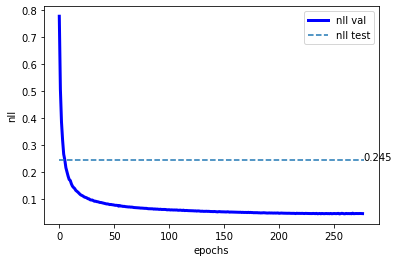

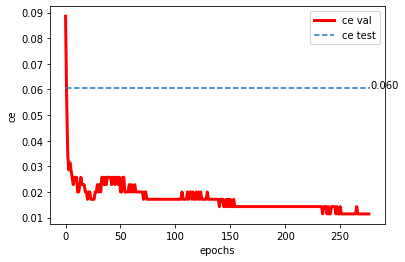

In [75]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

        
    if name[0:14] == "classifier_cnn":
        
        classnet =gen_ann(best_individual[-1])
        
        pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

# Maximum parameter indivdual plot


-> START classifier_cnn
Epoch: 0, val nll=0.4191013172694615, val ce=0.07428571428571429


C:\Users\lucyn\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 10, val nll=0.10466741834368025, val ce=0.02857142857142857
Epoch: 20, val nll=0.09361801317759923, val ce=0.025714285714285714
Epoch: 30, val nll=0.09077652079718454, val ce=0.025714285714285714
Epoch: 40, val nll=0.08785084571157183, val ce=0.02
Epoch: 50, val nll=0.08621098722730364, val ce=0.02
Epoch: 60, val nll=0.08574166008404323, val ce=0.02
Epoch: 70, val nll=0.08295896053314208, val ce=0.02
Epoch: 80, val nll=0.08260734404836383, val ce=0.02
Epoch: 90, val nll=0.08138759851455689, val ce=0.02
Epoch: 100, val nll=0.08150392387594496, val ce=0.02
Epoch: 110, val nll=0.08085065458502089, val ce=0.02
Epoch: 120, val nll=0.07993091063840049, val ce=0.02
Epoch: 130, val nll=0.08143414386681148, val ce=0.02
Epoch: 140, val nll=0.08067334609372276, val ce=0.02
-> FINAL PERFORMANCE: nll=0.2912763018469416, ce=0.06711409395973154


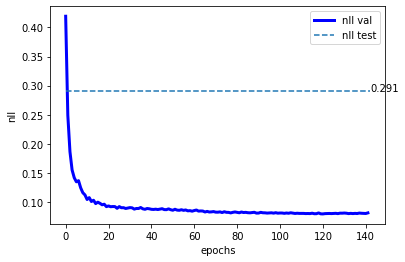

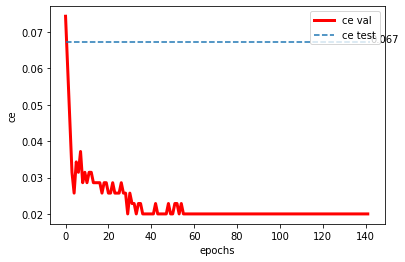

In [76]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

        
    if name[0:14] == "classifier_cnn":
        
        classnet =max_ann()

        pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "(max)_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="(max)_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="(max)_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

### Other plots were made in the old assignment files for a cleaner look